In [1]:
using Knet, Images

In [2]:
const GPU_ID = 0
const USE_GPU = (gpu() != -1) && (GPU_ID != -1) && (gpu(GPU_ID) != -1)

true

In [3]:
const T = Float32
atype = KnetArray{T}

Knet.KnetArray{Float32,N} where N

In [4]:
include(Knet.dir("data","mnist.jl"))
include(Knet.dir("data","imagenet.jl"))

xtrn, ytrn, xtst, ytst = mnist()

xtype = USE_GPU ? KnetArray : typeof(xtrn)
@assert xtype == (USE_GPU ? KnetArray : typeof(xtst))

dtrn = minibatch(xtrn, ytrn, 200, shuffle=true,  partial=true, xtype=xtype)
dtst = minibatch(xtst, ytst, 100, shuffle=false, partial=true, xtype=xtype)

INFO: Loading MNIST...


Knet.MB(Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], UInt8[0x07 0x02 … 0x05 0x06], 100, 10000, true, 1:10000, [28, 28, 1, 10000], [10000], Knet.KnetArray, Array{UInt8,1})

In [5]:
weights(Z_dim, H_dim; atype=Array{T}) = begin
    X_dim = 28 * 28
    D_dim = X_dim + Z_dim
    
    θd = [xavier(H_dim, D_dim),
          zeros(H_dim),
          xavier(1, H_dim),
          zeros(1)]
    θd = map(x -> convert(atype, x), θd)
    
    θg = [xavier(H_dim, Z_dim),
          zeros(H_dim),
          xavier(X_dim, H_dim),
          zeros(X_dim)]
    θg = map(x -> convert(atype, x), θg)
    
    θr = [xavier(H_dim, X_dim),
          zeros(H_dim),
          xavier(Z_dim, H_dim),
          zeros(Z_dim)]
    θr = map(x -> convert(atype, x), θr)

    θd, θg, θr
end

weights (generic function with 1 method)

In [6]:
G(θg, z) = begin
    v = θg[1] * z .+ θg[2]
    v = relu.(v)
    v = θg[3] * v .+ θg[4]
    v = sigm.(v)
    v
end

G (generic function with 1 method)

In [7]:
D(θd, x) = begin
    v = θd[1] * x .+ θd[2]
    v = relu.(v)
    v = dropout(v, 0.5)
    v = θd[3] * v .+ θd[4]
    v
end

D (generic function with 1 method)

In [8]:
R(θr, x) = begin
    v = θr[1] * x .+ θr[2]
    v = relu.(v)
    v = θr[3] * v .+ θr[4]
    v
end

R (generic function with 1 method)

In [9]:
sample_z(Z_dim, X_num) = convert(atype, randn(T, Z_dim, X_num))

sample_z (generic function with 1 method)

In [10]:
BCE(x, x̂) = -mean(x .* log.(x̂ .+ eps(T)) .+ (1 .- x) .* log.(1 .- x̂ .+ eps(T)))

BCE (generic function with 1 method)

In [11]:
MSE(x, x̂) = mean(sum((x - x̂) .* (x - x̂), 1))

MSE (generic function with 1 method)

In [12]:
loss_d(θd, θg, θr, x, z) = begin
    x_real = mat(x)
    x_fake = G(θg, z)
    z_fake = R(θr, x_real)

    BCE(1, sigm.(D(θd, [x_real; z_fake]))) + BCE(0, sigm.(D(θd, [x_fake; z])))
end

grad_loss_d = grad(loss_d)

(::gradfun) (generic function with 1 method)

In [13]:
loss_g(θg, θd, θr, z) = begin
    x_fake = G(θg, z)
    z_fake = R(θr, x_fake)
    
    -mean(D(θd, [x_fake; z])) + MSE(z_fake, z)
end

grad_loss_g = grad(loss_g)

(::gradfun) (generic function with 1 method)

In [14]:
loss_r(θr, θg, θd, x, z) = begin
    x_real = mat(x)
    x_fake = G(θg, z)
    z_fake = R(θr, x_fake)
    
    mean(D(θd, [x_real; z_fake])) + MSE(z_fake, z)
end

grad_loss_r = grad(loss_r)

(::gradfun) (generic function with 1 method)

In [15]:
report(θg, θd, θr, epoch) = begin
    z = sample_z(Z_dim, 200)
    println((:epoch, epoch),
            (:loss_g, loss_g(θg, θd, θr, z)))
end

report (generic function with 1 method)

In [16]:
Z_dim = 32; H_dim = 256
θd, θg, θr = weights(Z_dim, H_dim, atype=atype)

(Knet.KnetArray{Float32,N} where N[Knet.KnetArray{Float32,2}(Knet.KnetPtr(Ptr{Void} @0x00007faba4200000, 835584, 0, nothing), (256, 816)), Knet.KnetArray{Float32,1}(Knet.KnetPtr(Ptr{Void} @0x00007fab89e00000, 1024, 0, nothing), (256,)), Knet.KnetArray{Float32,2}(Knet.KnetPtr(Ptr{Void} @0x00007fab89e00400, 1024, 0, nothing), (1, 256)), Knet.KnetArray{Float32,1}(Knet.KnetPtr(Ptr{Void} @0x00007fab89e00800, 4, 0, nothing), (1,))], Knet.KnetArray{Float32,N} where N[Knet.KnetArray{Float32,2}(Knet.KnetPtr(Ptr{Void} @0x00007fab89c00000, 32768, 0, nothing), (256, 32)), Knet.KnetArray{Float32,1}(Knet.KnetPtr(Ptr{Void} @0x00007fab89e00a00, 1024, 0, nothing), (256,)), Knet.KnetArray{Float32,2}(Knet.KnetPtr(Ptr{Void} @0x00007faba42cc000, 802816, 0, nothing), (784, 256)), Knet.KnetArray{Float32,1}(Knet.KnetPtr(Ptr{Void} @0x00007fab89a00000, 3136, 0, nothing), (784,))], Knet.KnetArray{Float32,N} where N[Knet.KnetArray{Float32,2}(Knet.KnetPtr(Ptr{Void} @0x00007fab89800000, 802816, 0, nothing), (256, 7

In [17]:
epoch_num = 50

opt_d = optimizers(θd, Adam, lr=0.001, beta1=0.7)
opt_g = optimizers(θg, Adam, lr=0.001, beta1=0.7)
opt_r = optimizers(θr, Adam, lr=0.001, beta1=0.7)

@time begin
    for epoch = 1:epoch_num
        loss_running = 0
        for (x, y) = dtrn
            
            X_num = length(y)
            
            z = sample_z(Z_dim, X_num)

            dθd = grad_loss_d(θd, θg, θr, x, z)
            dθg = grad_loss_g(θg, θd, θr, z)
            dθr = grad_loss_r(θr, θg, θd, x, z)
            
            update!(θd, dθd, opt_d)
            update!(θg, dθg, opt_g)
            update!(θr, dθr, opt_r)
            
        end
        
        report(θg, θd, θr, epoch)
    end
end

(:epoch, 1)(:loss_g, 5.1871376f0)
(:epoch, 2)(:loss_g, 6.461492f0)
(:epoch, 3)(:loss_g, 6.209765f0)
(:epoch, 4)(:loss_g, 5.0946093f0)
(:epoch, 5)(:loss_g, 5.4047637f0)
(:epoch, 6)(:loss_g, 5.467854f0)
(:epoch, 7)(:loss_g, 5.5925817f0)
(:epoch, 8)(:loss_g, 5.1478066f0)
(:epoch, 9)(:loss_g, 5.3010197f0)
(:epoch, 10)(:loss_g, 6.042757f0)
(:epoch, 11)(:loss_g, 5.377378f0)
(:epoch, 12)(:loss_g, 6.1920567f0)
(:epoch, 13)(:loss_g, 5.479683f0)
(:epoch, 14)(:loss_g, 5.2582474f0)
(:epoch, 15)(:loss_g, 5.7104435f0)
(:epoch, 16)(:loss_g, 5.7485476f0)
(:epoch, 17)(:loss_g, 5.5676174f0)
(:epoch, 18)(:loss_g, 6.1963644f0)
(:epoch, 19)(:loss_g, 5.5820184f0)
(:epoch, 20)(:loss_g, 5.9823823f0)
(:epoch, 21)(:loss_g, 6.161896f0)
(:epoch, 22)(:loss_g, 5.30921f0)
(:epoch, 23)(:loss_g, 5.5957594f0)
(:epoch, 24)(:loss_g, 5.216908f0)
(:epoch, 25)(:loss_g, 6.623765f0)
(:epoch, 26)(:loss_g, 6.6943884f0)
(:epoch, 27)(:loss_g, 5.7023983f0)
(:epoch, 28)(:loss_g, 8.555585f0)
(:epoch, 29)(:loss_g, 7.658803f0)
(:epoch

In [18]:
function plot_dream_and_thought(θg; gridsize=(5, 5), scale=1.0)
    m, n = gridsize
    nimg = m * n
    
    z_dream = sample_z(Z_dim, nimg)
    x_dream = G(θg, z_dream)
    
    images = map(i -> reshape(Array(x_dream)[:, i], (28, 28, 1)), 1:nimg)
    
    grid = make_image_grid(images; gridsize=gridsize, scale=scale)
    display(colorview(Gray, grid))
    
    z_thought = R(θr, x_dream)
    x_thought = G(θg, z_thought)
    
    images = map(i -> reshape(Array(x_thought)[:, i], (28, 28, 1)), 1:nimg)
    
    grid = make_image_grid(images; gridsize=gridsize, scale=scale)
    display(colorview(Gray, grid))
    
    print("MSE between dream and thought is: $(MSE(x_dream, x_thought)).")
    
    x_dream, x_thought
end

plot_dream_and_thought (generic function with 1 method)

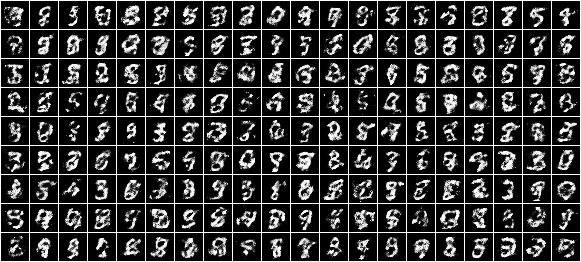

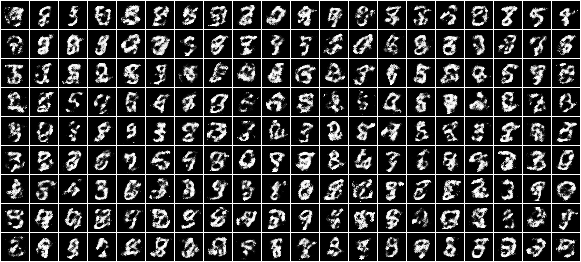

MSE between dream and thought is: 2.2989373.

(Knet.KnetArray{Float32,2}(Knet.KnetPtr(Ptr{Void} @0x00007fab2ef6b600, 564480, 0, nothing), (784, 180)), Knet.KnetArray{Float32,2}(Knet.KnetPtr(Ptr{Void} @0x00007fab3756b600, 564480, 0, nothing), (784, 180)))

In [19]:
x_dream, x_thought = plot_dream_and_thought(θg; gridsize=(20, 9))